<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/Titanic/4_1_Introduction_to_Ensembling_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

캐글 필사4
* 원본 : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [ ]:
# kaggle json
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


# Introduction

이 노트북은 기본 학습 모델을 병합 하는 방법, 특히 Stacking에 대한 매우 기본적이고 간단한 입문서 입니다.

스태킹은 간단히 말해서 처음(기본) 모델이 예측한 Prediction을 second모델의 학습에 사용하는 것 입니다.

많은 우승자가 staking을 사용해서 우승하였즈만, stacking에 대한 노트북은 적은것 같아 해당 노트북이 그 공백을 어느정도 채울수있기를 바랍니다

스크립트는 0.808의 공개 LB 점수를 제공하며 이는 상위 9 %에 도달하고 4 분 미만으로 실행됩니다. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import re
import sklearn
import xgboost as xgb

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold


# Feature Exploration, Engineering and Cleaning

대부분의 커널이 구조화되는 방식과 매우 유사하게 진행할 것입니다. 즉, 먼저 데이터를 탐색하고 features 엔지니어링 하고 모든 categorical  features을 수치 형으로 인코딩합니다.

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

PassengerId = test['PassengerId']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리의 임무는 어떻게 든 범주 형 변수에서 정보를 추출하는 것입니다.

## Feature Engineering

In [ ]:
full_data= [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Nmae_length'] = test['Name'].apply(len)
# Cabin이 있었는지
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

# feature engineering step
# create Family size 
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create IsAlone
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove Null in Embarked
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove Nulls in Fare, Create CategoricalFare
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
# pd.qcut : [4.2, 6.5] 처럼 범위를 반환, 적당히 같은 개수로 묶음
train['CategoricalFare'] = pd.qcut(train['Fare'], 4) 

# create CategoricalAge
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std,
                                           age_avg + age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
# pd.cut : 동일한 길이로 묶음
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Passenger Name에서 title을 추출하는 함수
def get_title(name):
  title_search = re.search('([A-Za-z]+)\.', name)
  if title_search:
    return title_search.group(1)
  return ''

# create Title
for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

# 수가 적은 tilte들은 Rare로 만든다
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',
                                               'Capt', 'Col','Don', 
                                               'Dr', 'Major', 'Rev', 'Sir', 
                                               'Jonkheer', 'Dona'], 'Rare')

  dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', "Miss")
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
  # mapping Sex
  dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

  # mapping titles
  title_mapping = {'Mr':1, "Miss":2, "Mrs":3, 'Master': 4, 'Rare': 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  # Mapping Fare
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  #mapping Age
  dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[dataset['Age'] > 64, 'Age'] = 4;

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis = 1)

이제 우리는 깔끔한 feature들을 얻었고, 관련정보를 추출하고, 범주형을 삭제했으므로 feature가 모두 숫자여야 합니다.

## visualizations 

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [ ]:
train.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age            0
Parch          0
Fare           0
Embarked       0
Name_length    0
Has_Cabin      0
FamilySize     0
IsAlone        0
Title          0
dtype: int64

### Pearson Correlation heatmap

feature들이 서로 얼마나 상관관계가 있는지 살펴보겠습니다

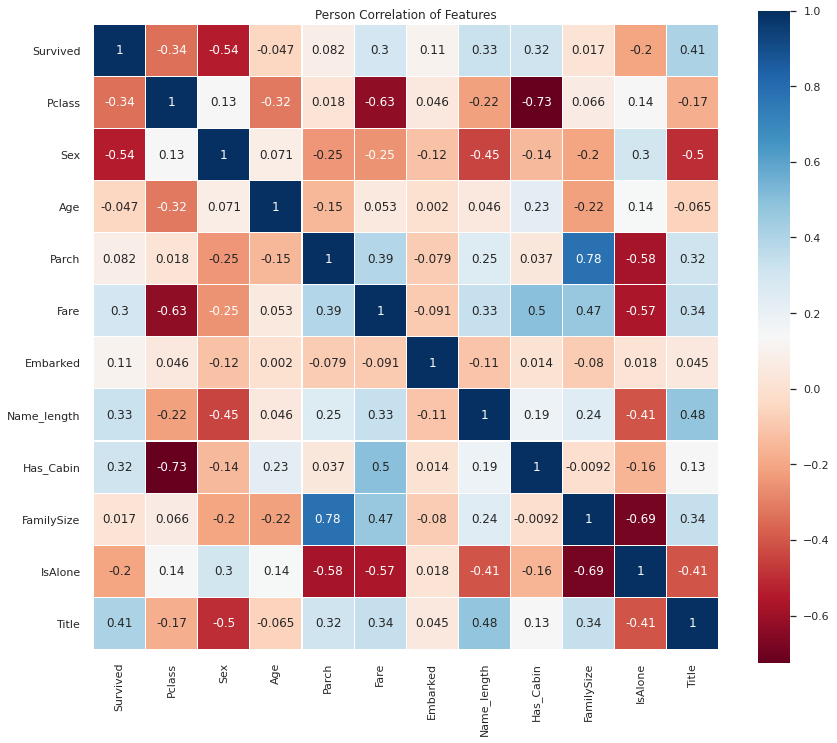

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features')
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

Pearson Correlation 플롯이 우리에게 말할 수있는 한 가지는 서로 강한 상관 관계가있는 특성이 너무 많지 않다는 것입니다. 이는 학습 모델에 이러한 기능을 제공하는 관점에서 볼 때 유용합니다. 이는 학습 세트에 중복되거나 불필요한 데이터가 많지 않고 각 기능에 고유 한 정보가 포함되었기 때문입니다. 가장 상관 관계가있는 두 가지 기능은 가족 규모와 Parch (부모 및 자녀)입니다. 이 연습에서는 두 기능을 그대로 두겠습니다.

### Pairplots
이제 하나의 특성에서 다른특성으로의 데이터 분포를 보기위해 Pairplot을 보겠습니다.

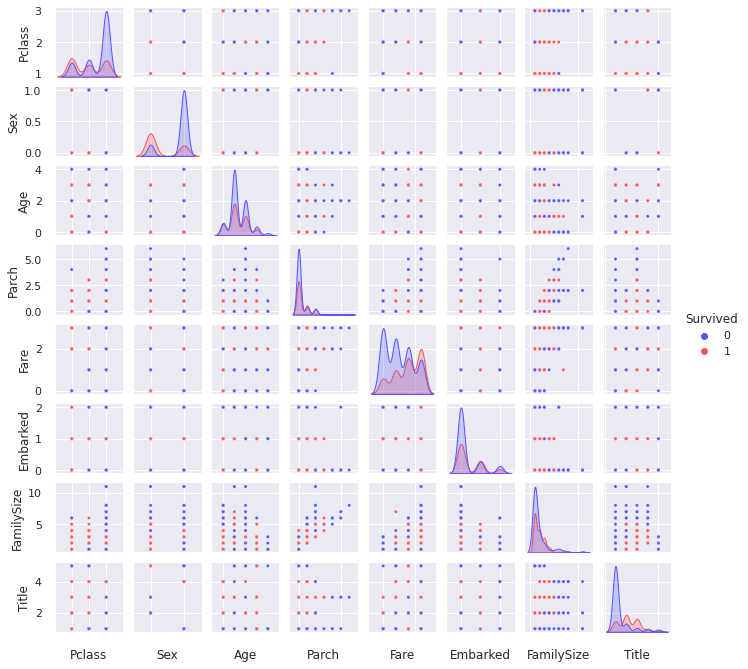

In [ ]:
sns.set(font_scale=1)
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], 
       hue='Survived', palette = 'seismic',size=1.2,
       diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

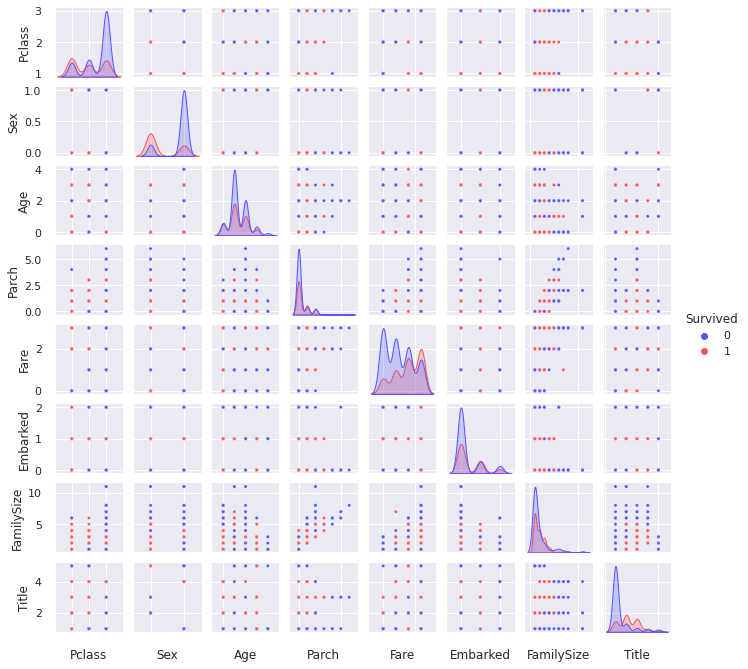

In [ ]:
sns.set(font_scale=1)
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'Title']], 
       hue='Survived', palette = 'seismic',size=1.2,
       diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models


더 편리하도록 파이썬의 클래스를 사용하도록 하겠습니다.

sklearn의 공통적인 메서드 (train, predict, fit)을 확장할 수 있는 SklearnHelper클래스를 만들 것입니다.

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# classifier, parameter를 매개변수로 받는다.
# 생성자로 classifier를 정의한다.
class SklearnHelper(object):
  def __init__(self, clf, seed = 0, params = None):
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def predict(self, x):
    return self.clf.predict(x)

  def fit(self, x ,y):
    return self.clf.fit(x,y)
  
  def feature_importances(self, x, y):
    print(self.clf.fit(x,y).feature_importances_)


### Out-of-Fold Predictions
stacking은 첫번째 모델의 예측을 두번째모델의 학습을 위한 입력으로 사용합니다.

하지만 전체 학습데이터로 첫번째모델을 학습하고 전체 테스트세트에 대한 예측을 생성한 뒤 이를 두번째 모델에 넣는것은 할 수 없습니다.

데이터의 누수때문입니다. 이는 과적합의 위험이있습니다.

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
  oof_train = np.zeros((ntrain,)) # (891,)
  oof_test = np.zeros((ntest,)) # (418,)
  oof_test_skf = np.empty((NFOLDS, ntest)) # (5, 418)


  for i, (train_index, test_index) in enumerate(kf.split(x_train)):
    # train을 kfold로 나눠서 x_tr은 학습, x_te는 validation용 test로 사용한다
    print('i= ', i)
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index] # kfold로 인해 나눠진 test_index, 원래 train이였다.

    clf.train(x_tr, y_tr)

    # validation용으로 나눈 x_te를 예측 후 oof_train의 해당하는 index에 넣는다.
    # kfold정의시 shuffle을 False로 주었기때문에 kfold마다 겹치지않는다.
    oof_train[test_index] = clf.predict(x_te)
    
    # i번째 행에 kfold로 나뉜 4개의 데이터셋으로 학습한 모델의 예측을 넣는다.
    # 예측을 위해 넣은 데이터는 같지만, 모델학습에 사용한 데이터가 다르다.
    oof_test_skf[i,:]  = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0) # x축 방향으로 평균을 낸다(세로) (5,418) -> (1,418)
  # oof_train : train을 kfold로 나눠서 예측한 결과
  # oof_test : 실제 test를 예측한 결과
  return oof_train.reshape(-1,1), oof_test.reshape(-1,1) # (891,1) , (418,1)

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(train)):
  if i<2:
    print('i=',i,': ',train_index, test_index)

i= 0 :  [179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413 414 415 416 417 418 419 420 421 422 42

# Generating our Base First_Level Models
이제 첫번째 모델로 5개의 학습모델을 준비하겠습니다.

* Random Forest classifier
* Extra Trees classifier
* AdaBoost classifer
* Gradient Boosting classifer
* Support Vector Machine


### Parameters
 * n_jobs : 사용할 코어 수. -1로하면 모든 코어를 사용
 * n_estimators : 학습모델의 분류 트리 수(기본값 10)
 * max_depth : 트리 최대깊이
 * verbose : 학습과정에서 텍스트를 출력할지 여부. 0은 모든 텍스트를 억제, 3은 모든 반복에서 트리학습프로세스를 출력


In [ ]:
# random forest parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' : 0
}

# Extra trees parameters
et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

#AdaBoost parameters
ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75,
}

# Gradient boost parameters
gb_params = {
    'n_estimators' : 500,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# Support vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

이제 앞서 정의한 Helper Sklearn Class를 통해 5 개의 학습 모델을 나타내는 5 개의 객체를 생성하겠습니다.

In [ ]:
# create 5 objects 
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf = SVC, seed=SEED, params=svc_params)

### train, test를 Numpy배열로 만들기
원래 데이터 프레임에서 NumPy 배열을 생성하여 분류 자에 입력 할 학습 및 테스트 데이터를 준비 할 수 있습니다.

In [ ]:
y_train = train['Survived'].ravel() # 평평하게 해주는 함수
train = train.drop(['Survived'], axis = 1)
x_train = train.values # 굳이 numpy로 추출해서 넣지 않아도 된다.
x_test = test.values

In [ ]:
y_train.shape

(891,)

In [ ]:
train.shape

(891, 11)

In [ ]:
test.shape

(418, 11)

### 첫번째수준의 예측

이제 train과 test세트를 5개의 기본 분류기에 공급하고, Out-Of-Fold예측 함수를 사용하여 첫번째 수준의 예측을 생성합니다

In [ ]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Traning is complete')

i=  0
i=  1
i=  2
i=  3
i=  4
i=  0
i=  1
i=  2
i=  3
i=  4
i=  0
i=  1
i=  2
i=  3
i=  4
i=  0
i=  1
i=  2
i=  3
i=  4
i=  0
i=  1
i=  2
i=  3
i=  4
Traning is complete


In [ ]:
print(et_oof_train.shape, et_oof_test.shape)
et_oof_train[:10], et_oof_test[:10] # et_oof_test는 각 kfold모델예측의 평균이기에 0과1 사이값

(891, 1) (418, 1)


(array([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]]), array([[0. ],
        [0.8],
        [0. ],
        [0. ],
        [0.6],
        [0. ],
        [1. ],
        [0. ],
        [1. ],
        [0. ]]))

### feature importance

이제 첫 번째 수준 분류기를 배웠으므로 Sklearn 모델의 매우 멋진 기능을 활용할 수 있으며, 이는 매우 간단한 코드 줄로 학습 및 테스트 세트의 다양한 기능의 중요성을 출력하는 것입니다.

Sklearn 문서에 따르면, 대부분의 분류기는 .featureimportances를 입력하기 만하면 기능 중요도를 반환하는 속성이 내장되어 있습니다. 따라서 우리는 함수 earliand 플롯을 통해이 매우 유용한 속성을 호출 할 것입니다.

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)
# svc는 feature_importances가 없다

[0.12876152 0.19847739 0.03169984 0.02082673 0.07104515 0.02360243
 0.10929349 0.06429573 0.06490663 0.01352368 0.27356741]
[0.12123131 0.38113666 0.02797757 0.01651517 0.05622717 0.02809296
 0.04822353 0.08510909 0.04266002 0.02146268 0.17136385]
[0.03  0.012 0.016 0.064 0.04  0.01  0.69  0.012 0.052 0.004 0.07 ]
[0.08754466 0.00927078 0.04865564 0.01296717 0.053778   0.02657139
 0.17596384 0.03616845 0.11210312 0.00476602 0.43221092]


In [ ]:
rf_features =[0.12876152, 0.19847739, 0.03169984, 0.02082673, 0.07104515, 0.02360243,
               0.10929349, 0.06429573, 0.06490663, 0.01352368, 0.27356741]
et_features =[0.12123131, 0.38113666, 0.02797757, 0.01651517, 0.05622717, 0.02809296,
              0.04822353, 0.08510909, 0.04266002, 0.02146268, 0.17136385]
ada_features =[0.03,  0.012, 0.016, 0.064, 0.04, 0.01, 0.69,  0.012, 0.052, 0.004, 0.07 ]
gb_features =[0.08754466, 0.00927078, 0.04865564, 0.01296717, 0.053778, 0.02657139,
              0.17596384, 0.03616845, 0.11210312, 0.00476602, 0.43221092]

In [ ]:
cols = train.columns.values 
 #array(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length','Has_Cabin', 'FamilySize', 'IsAlone', 'Title'], dtype=object)
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.128762,0.121231,0.030,0.087545
1,Sex,0.198477,0.381137,0.012,0.009271
2,Age,0.031700,0.027978,0.016,0.048656
3,Parch,0.020827,0.016515,0.064,0.012967
4,Fare,0.071045,0.056227,0.040,0.053778
5,Embarked,0.023602,0.028093,0.010,0.026571
6,Name_length,0.109293,0.048224,0.690,0.175964
7,Has_Cabin,0.064296,0.085109,0.012,0.036168
8,FamilySize,0.064907,0.042660,0.052,0.112103
9,IsAlone,0.013524,0.021463,0.004,0.004766


### feature importance 시각화

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.128762,0.121231,0.030,0.087545,0.091884
1,Sex,0.198477,0.381137,0.012,0.009271,0.150221
2,Age,0.031700,0.027978,0.016,0.048656,0.031083


In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


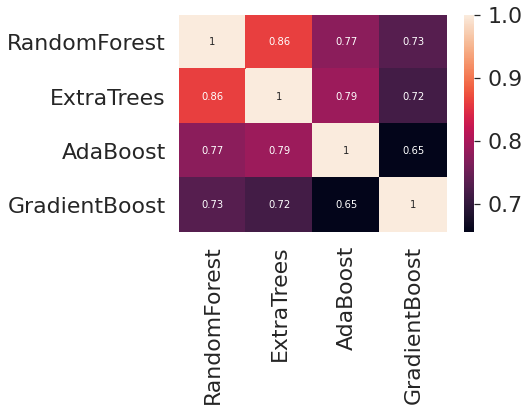

In [ ]:
sns.heatmap(base_predictions_train.corr(), annot=True)

feature importance가 서로다른 모델의 장점에 대한 기사와 kaggle우승자 이야기가 많습니다

In [ ]:
x_train = np.concatenate(( 
    et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( 
    et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
print(x_train.shape, x_test.shape)

x_train[:10], x_test[:10]

(891, 5) (418, 5)


(array([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), array([[0. , 0. , 0. , 0. , 0. ],
        [0.8, 1. , 1. , 1. , 1. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0.6, 1. , 1. , 1. , 1. ],
        [0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. ],
        [0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. ],
        [0. , 0. , 0. , 0. , 0. ]]))


이제 x_train 및 x_test로 1 단계 학습 및 테스트 예측을 연결하고 결합 했으므로 이제 2 단계 학습 모델을 맞출 수 있습니다.

## XGBoost
여기서 우리는 부스트 트리 학습 모델 인 XGBoost를 선택합니다. 

XGBClassifier를 호출하고이를 첫 번째 수준의 train 과 target 데이터에 맞추고 학습 된 모델을 사용하여 다음과 같이 테스트 데이터를 예측합니다.

In [ ]:
gbm = xgb.XGBClassifier(
    # learning_rate = 0.02,
    n_estimators = 2000,
    max_depth=4,
    min_child_weight = 2,
    # gamma=1,
    gamma=0.9,
    subsample = 0.8,
    colsample_bytree=0.8,
    objective = 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

max_depth : tree의 깊이, 너무깊으면 과적합위험이있다.

gamma : 트리의 리프노드에서 추가 파티션을 만드는데 필요한 최소 손실 감소. 클수록 알고리즘이 보수적이다

eta : 과적합을 방지하기위해 각 부스팅 단계에서 사용되는 단계크기축소

## submission file 생성
마지막으로 모든 1 단계 및 2 단계 모델을 훈련하고 맞추 었으므로 이제 다음과 같이 타이타닉 대회에 제출하기위한 적절한 형식으로 예측을 출력 할 수 있습니다.

In [ ]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

public score :  0.77272